dict_keys(['unit', 'Ks', 'TSi', 'TP', 'P', 'S', 'T', 'Mg', 'Ca', 'BT', 'pCO2', 'fCO2', 'TA', 'CO3', 'HCO3', 'CO2', 'DIC', 'pH', 'TS', 'TF', 'H', 'CAlk', 'BAlk', 'PAlk', 'SiAlk', 'OH', 'Hfree', 'HSO4', 'HF'])


<IPython.core.display.Javascript object>


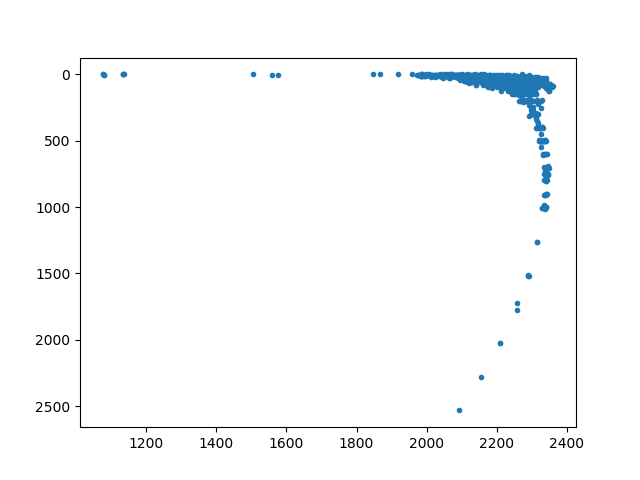

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cbsyst as cb
import pandas as pd
# you may need to change this, depending on where your data file is
filename = 'week03_wcoa_cruise/WCOA2013_hy1.csv' 
df = pd.read_csv(filename,header=31,na_values=-999,
                 parse_dates=[[8,9]])

# It will use defaults for some missing values. We use the max.
Csw = cb.Csys(pH=df['PH_TOT'], TA=df['ALKALI'], T=df['CTDTMP'], S=df['CTDSAL'], P=df['CTDPRS'])
# Some keys have their own keys.
print(Csw.keys())

plt.figure()
plt.plot(Csw['DIC'], df['CTDPRS'], '.')
plt.gca().invert_yaxis()


In [2]:
OmegaA = Csw['Ca']*Csw['CO3']/(Csw.Ks['KspA']*1e6)

<IPython.core.display.Javascript object>


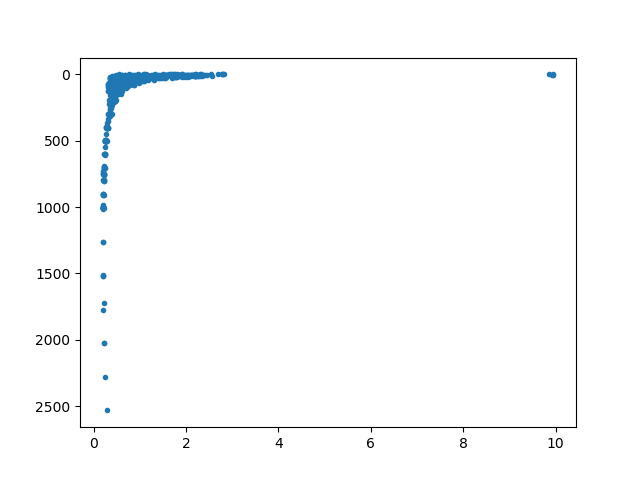

In [3]:
plt.figure()
plt.plot(OmegaA, df['CTDPRS'], '.')
plt.gca().invert_yaxis()

In [4]:
# Add to existing pandas df
df['OmegaA'] = OmegaA

<IPython.core.display.Javascript object>


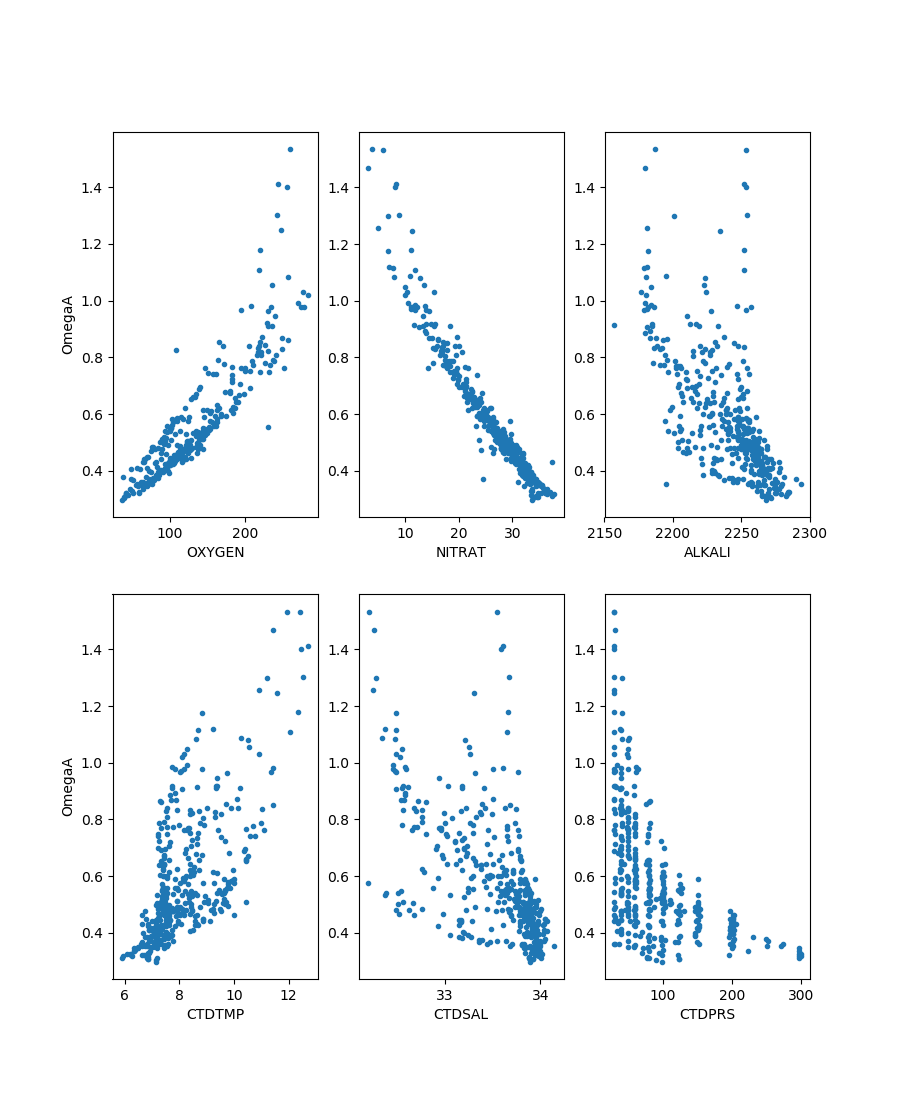

In [16]:
plt.figure(figsize=[9, 11])

Csw = cb.Csys(pH=df['PH_TOT'], TA=df['ALKALI'], T=df['CTDTMP'], S=df['CTDSAL'], P=df['CTDPRS'])
# Can OmegaA, but what does that really do?
Csw['OmegaA'] = OmegaA
#Csw_sub = Csw[Csw['P'] > 30]
#Csw_sub = Csw[Csw_sub['P'] < 300]
#dfsub = df[df['CTDPRS'] > 30]
#dfsub = dfsub[dfsub['CTDPRS'] < 300]
dfsub = df[(df['CTDPRS'] > 30) & (df['CTDPRS'] < 300)]

#variables_to_plot = ['pH','TA','T','S','P']
variables_to_plot = ['OXYGEN','NITRAT','ALKALI','CTDTMP','CTDSAL','CTDPRS']

i = 0
for var in variables_to_plot:
    i = i + 1
    plt.subplot(2, 3, i)
    plt.plot(dfsub[var],dfsub['OmegaA'],'.', label=var)
    if i == 1 or i == 4:
        plt.ylabel('OmegaA')
    plt.xlabel(var)
    
#plt.legend(loc=[0.2, 0.1])
# Note that it's possible to plot Csw, if OmegaA is included:
#plt.plot(Csw.OmegaA, Csw.TA, '.')

In [24]:
# First, elimiate rows with nan values
print(len(dfsub))
dfsub = dfsub[np.isfinite(dfsub['OmegaA']+dfsub['OXYGEN']+dfsub['CTDTMP']+dfsub['CTDSAL']+dfsub['CTDPRS']+dfsub['NITRAT'])]
print(len(dfsub))


# Response variable OmegaA is already defined.
# Explanatory variable matrix
# T, S, p, O2, N
# Rows - one per data value
# Columns - one per input variable, plus one for C0
A = np.ones([len(dfsub['OmegaA']), 6])*np.nan
A[:, 0] = 1
A[:, 1] = dfsub['CTDTMP']
A[:, 2] = dfsub['CTDSAL']
A[:, 3] = dfsub['CTDPRS']
A[:, 4] = dfsub['OXYGEN']
A[:, 5] = dfsub['NITRAT']
y = dfsub['OmegaA']
regression = np.linalg.lstsq(A, y)
print(regression[0])

299
290
[ -3.07750516e-01   3.19305644e-02   2.83171680e-02   1.99215122e-04
   1.13431498e-03  -1.92288348e-02]


<IPython.core.display.Javascript object>


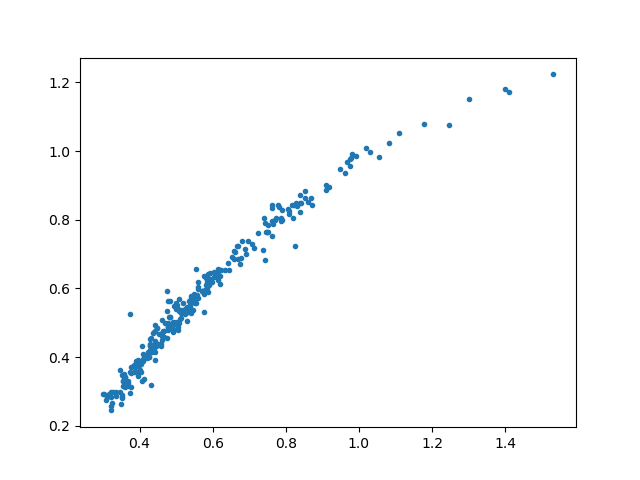

In [25]:
# Calculate OmegaA from the result for plotting
# Use the vector of C0, C1, ... CN times each row of A
Omega_fit = np.dot(A, regression[0])  #A @ regression[0]

plt.figure()
plt.plot(dfsub['OmegaA'], Omega_fit, '.')

In [19]:
df.columns

Index(['DATE_TIME', 'EXPOCODE', 'SECT_ID', 'LEG', 'LINE', 'STNNBR', 'CASTNO',
       'BTLNBR', 'BTLNBR_FLAG_W', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'CTDPRS',
       'CTDTMP', 'CTDSAL', 'CTDSAL_FLAG_W', 'CTDOXY', 'CTDOXY_FLAG_W',
       'SALNTY', 'SALNTY_FLAG_W', 'OXYGEN', 'OXYGEN_FLAG_W', 'SILCAT',
       'SILCAT_FLAG_W', 'NITRAT', 'NITRAT_FLAG_W', 'NITRIT', 'NITRIT_FLAG_W',
       'PHSPHT', 'PHSPHT_FLAG_W', 'AMMONI', 'AMMONI_FLAG_W', 'TCARBN',
       'TCARBN_FLAG_W', 'ALKALI', 'ALKALI_FLAG_W', 'PH_TOT', 'PH_TOT_FLAG_W',
       'PH_TMP', 'CO32', 'CO32__FLAG_W', 'CHLORA', 'OmegaA'],
      dtype='object')

In [20]:
print(A)
print(regression[0])

[[   1.        6.6459   33.942   202.5      75.9      34.35  ]
 [   1.        7.2983   33.474   123.8     183.       23.79  ]
 [   1.        7.3441   32.795    80.5     256.       16.14  ]
 ..., 
 [   1.       10.7555   33.647    60.5     161.5      19.69  ]
 [   1.       11.437    33.606    40.4     208.       13.67  ]
 [   1.       12.4522   33.589    30.2     254.5       8.12  ]]
[ 0.3547028   0.60503673  0.86129268  1.02037793  0.46426102  0.57124676]


In [21]:
ooo = .354 + .605*7.34 + .86* 32.795 + 1.02* 80.5 + .464*256 + .572*16.15
print(ooo)

243.1302
